In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
from awesome.run.functions import plot_as_image

D:\projects\AWESOME\awesome\dataset\sisbosi_dataset.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
img = Image.open('../data/datasets/convexity_dataset/img/img_1.png')
(width, height) = (img.width, img.height)
img = np.array(img.resize((width, height)))/255.0

print(img.shape)

(152, 250, 3)


In [18]:
def getPixelData(mask, img):
    ny,nx,nc = img.shape
    y,x = np.where(mask==1)

    number_of_scribbled_pixels = np.sum(mask)
    pixelData = np.zeros([number_of_scribbled_pixels, nc])

    for i in range(nc):
        pixelData[:,i] = img[y,x,i]
    
    coordinates = np.concatenate((y[:,np.newaxis]/ny,x[:,np.newaxis]/nx), axis = 1)
        
    return pixelData, coordinates

In [19]:
ny,nx,nc = img.shape
mask = np.zeros([ny,nx], dtype=bool)
mask[::2,::2] = 1
y_train, x_train = getPixelData(mask, img)
print(y_train.shape, x_train.shape)

(9500, 3) (9500, 2)


In [20]:
x_train

array([[0.        , 0.        ],
       [0.        , 0.008     ],
       [0.        , 0.016     ],
       ...,
       [0.98684211, 0.976     ],
       [0.98684211, 0.984     ],
       [0.98684211, 0.992     ]])

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ourSimpleNetwork(nn.Module):
    
    def __init__(self, d_in, d_features, d_hidden, d_out, factor):
        super().__init__()
        
        self.register_buffer("A", torch.tensor(factor*torch.randn(d_in, d_features), requires_grad=False))
        self.register_buffer("b", torch.tensor(torch.randn(d_features), requires_grad=False))
        self.fc1 = nn.Linear(d_features, d_hidden)
        self.fc2 = nn.Linear(d_hidden, d_hidden)
        self.fc3 = nn.Linear(d_hidden, d_hidden)
        self.fc4 = nn.Linear(d_hidden, d_out)
    
    def forward(self,x):
        #x = torch.cat((torch.sin(x@self.A +self.b),torch.cos(x@self.A+self.b)),1)
        x = torch.cos(x@self.A+self.b)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [23]:
from torch.utils.data import DataLoader, TensorDataset
device = 'cuda:0'

d_in = x_train.shape[1]
d_out = y_train.shape[1]
d_features = 20
factor = 30
d_hidden = 350
ourNet = ourSimpleNetwork(d_in,d_features,d_hidden,d_out,factor)

x_train_torch = torch.from_numpy(x_train).float()
y_train_torch = torch.from_numpy(y_train).float()

lossFunction = nn.MSELoss()
learningRate = 1e-3

ourNet.to(device)
optimizer = torch.optim.Adam(ourNet.parameters(), lr = learningRate)

train_data = TensorDataset(x_train_torch, y_train_torch)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

n_epochs = 150
for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        prediction = ourNet(x_batch)
        loss = lossFunction(prediction,y_batch)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if np.mod(epoch,10)==0:
        print(epoch, loss.item())

ourNet.cpu()

C:\Users\Schneider\AppData\Local\Temp\ipykernel_24148\461410498.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("A", torch.tensor(factor*torch.randn(d_in, d_features), requires_grad=False))
C:\Users\Schneider\AppData\Local\Temp\ipykernel_24148\461410498.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("b", torch.tensor(torch.randn(d_features), requires_grad=False))


0 0.03438810631632805
10 0.004273959435522556
20 0.006703945808112621
30 0.002031288342550397
40 0.0017434738110750914
50 0.001261782948859036
60 0.0010056346654891968
70 0.0007355420384556055
80 0.0007874887087382376
90 0.0008094458025880158
100 0.0008476446964778006
110 0.0006256822380237281
120 0.0009069002699106932
130 0.0003871397639159113
140 0.00045022089034318924


0.99590814 0.0023589605


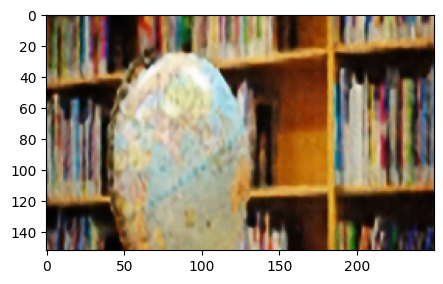

tensor(970.8301)


In [26]:
#y_pred = ourNet(x_train_torch).detach().numpy().reshape([50,50,nc])
xv, yv = torch.meshgrid([torch.arange(0,ny), torch.arange(0,nx)])
x_test = torch.cat((torch.reshape(xv, (nx*ny,1)),torch.reshape(yv, (nx*ny,1))), 1).float()/nx
y_pred = ourNet(x_test).detach().numpy().reshape(img.shape)

print(y_pred.max(), y_pred.min())
plt.figure(figsize=(5,10))
plt.imshow(y_pred)
plt.show()
print(ourNet.A.var())

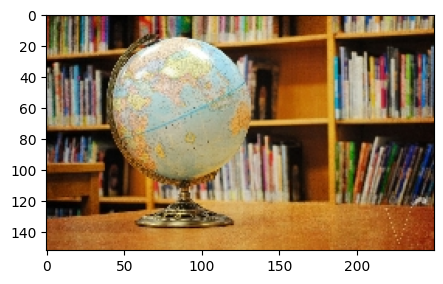

In [30]:
plt.figure(figsize=(5,10))
#plt.imshow(y_train_torch.reshape([50,50,nc]))
plt.imshow(img)
plt.show()